In [1]:
# === Step 0: Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [4]:
# === Step 1: Load and Preprocess the Data ===
# Load datasets
weather_df = pd.read_csv('weather_features.csv')
energy_df = pd.read_csv('energy_dataset.csv')

In [5]:
# === Corrected Preprocessing ===
energy_df['time'] = pd.to_datetime(energy_df['time'], utc=True).dt.tz_localize(None)
start_time = energy_df['time'].min()

# Force weather to match energy
weather_df = weather_df.iloc[:len(energy_df)].copy()
weather_df['datetime'] = pd.date_range(start=start_time, periods=len(weather_df), freq='h')

# Merge
merged_df = pd.merge(energy_df, weather_df, left_on='time', right_on='datetime', how='inner')
merged_df = merged_df.drop(columns=['city_name', 'datetime', 'dt_iso'])

# Feature engineering
merged_df['hour'] = merged_df['time'].dt.hour
merged_df['dayofweek'] = merged_df['time'].dt.dayofweek
merged_df['month'] = merged_df['time'].dt.month
merged_df['is_weekend'] = merged_df['dayofweek'].isin([5, 6]).astype(int)

# Smooth and drop missing
merged_df['load_smoothed'] = merged_df['total load actual'].rolling(window=3, center=True).mean()
filtered_df = merged_df.dropna(subset=['load_smoothed'])

print("✅ Filtered dataset shape:", filtered_df.shape)


✅ Filtered dataset shape: (34983, 49)


In [6]:
# === Step 2: Feature Selection and Scaling ===
features = [
    'temp', 'humidity', 'pressure', 'wind_speed', 'clouds_all',
    'hour', 'dayofweek', 'month',
    'total load forecast', 'is_weekend'
]
target = 'load_smoothed'

# Scale input features and target separately
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(filtered_df[features])
y_scaled = scaler_y.fit_transform(filtered_df[[target]])

In [7]:
# === Step 3: Create LSTM Sequences ===
def create_sequences(X, y, seq_length=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

SEQ_LEN = 24
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)

# Align time with sequences
filtered_time = filtered_df['time'].iloc[SEQ_LEN:].reset_index(drop=True)


In [8]:
# === Step 4: Train/Test Split ===
train_idx = filtered_time < '2018-01-01'
test_idx = filtered_time >= '2018-01-01'

X_train, X_test = X_seq[train_idx], X_seq[test_idx]
y_train, y_test = y_seq[train_idx], y_seq[test_idx]

# === Step 5: Define and Train LSTM Model ===
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, X_train.shape[2])),
    LSTM(32),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - loss: 0.0278
Epoch 2/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - loss: 0.0045
Epoch 3/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - loss: 0.0021
Epoch 4/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - loss: 0.0015
Epoch 5/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - loss: 0.0013
Epoch 6/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - loss: 0.0012
Epoch 7/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 0.0012
Epoch 8/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - loss: 0.0011
Epoch 9/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - loss: 0.0010
Epoch 10/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 0.0010
Epoch 11/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 0.0010
Epoch 12/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - loss: 9.7389e-04
Epoch 13/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - loss: 9.6939e-04
Epoch 14/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 9.7750e-04
Epoch 15/20
410/4

In [9]:
# === Step 6: Prediction and Inverse Transform ===
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


In [10]:
# === Step 7: Evaluation Metrics ===
# Calculate MAE, RMSE, MAPE, R², and CV
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)
cv = rmse / np.mean(y_test_inv)  # Coefficient of Variation

# Print evaluation results
print("📊 Model Evaluation Metrics:")
print(f"MAE  : {mae:.2f} MW")
print(f"RMSE : {rmse:.2f} MW")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.4f}")
print(f"CV   : {cv:.4f}")

📊 Model Evaluation Metrics:
MAE  : 465.90 MW
RMSE : 611.07 MW
MAPE : 1.63%
R²   : 0.9815
CV   : 0.0210


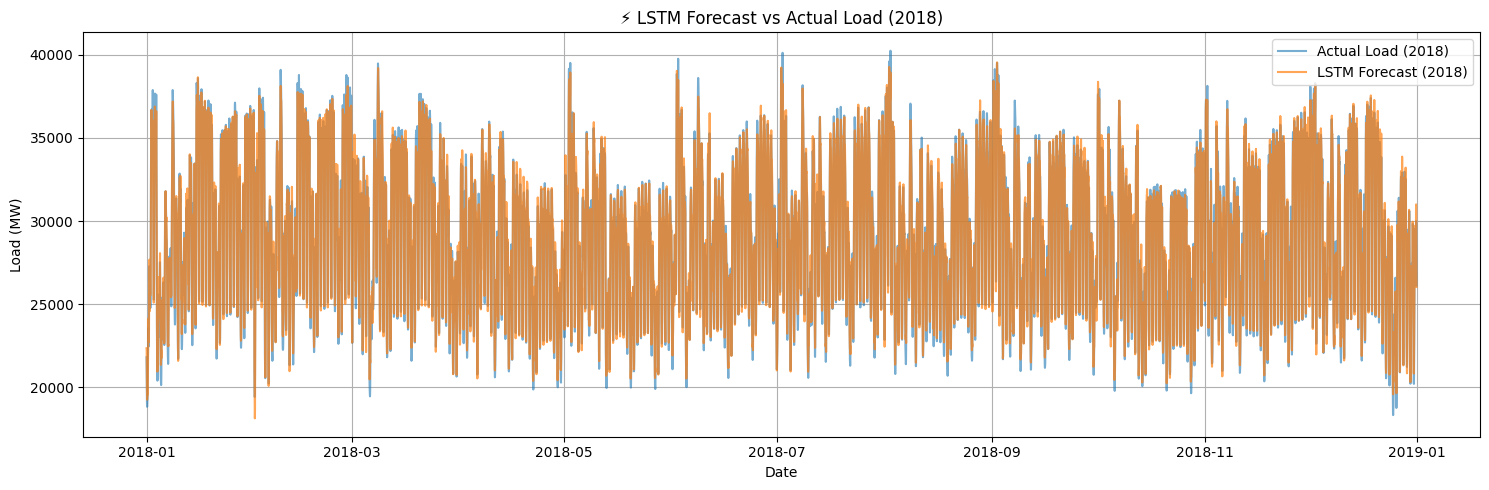

In [11]:
# === Step 8: Plot Predictions vs Actual ===
# Prepare test dates
test_dates = filtered_time[test_idx].reset_index(drop=True)

# Plot
plt.figure(figsize=(15, 5))
plt.plot(test_dates, y_test_inv, label="Actual Load (2018)", alpha=0.6)
plt.plot(test_dates, y_pred_inv, label="LSTM Forecast (2018)", alpha=0.7)
plt.title("⚡ LSTM Forecast vs Actual Load (2018)")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


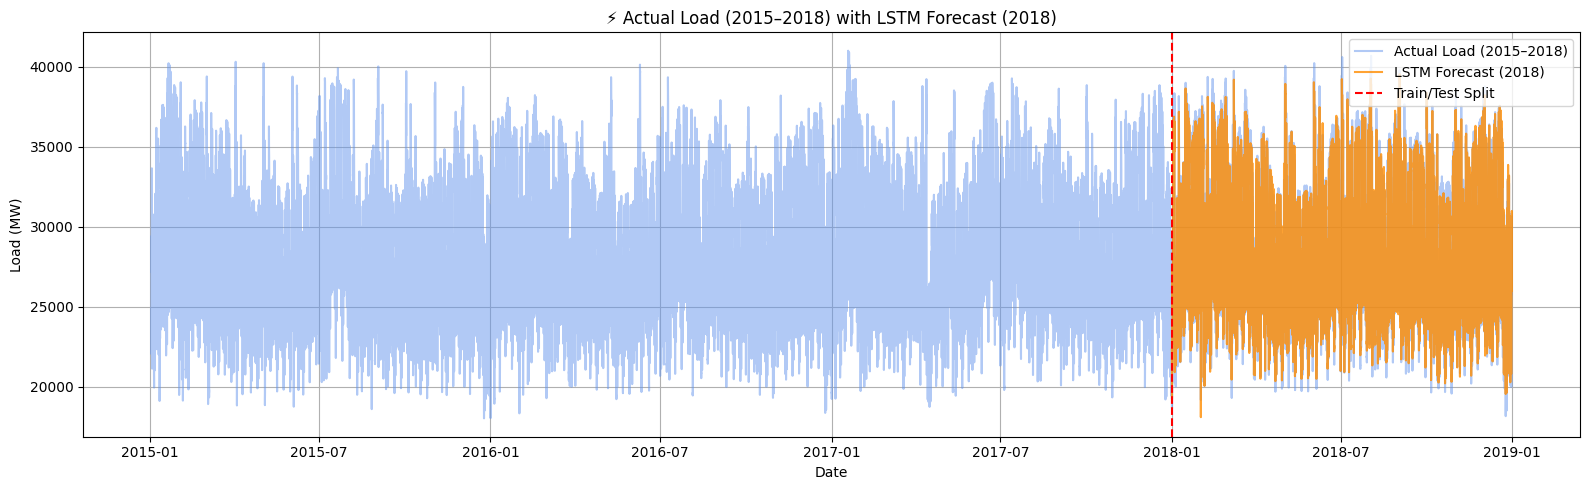

In [12]:
# === Step 9: Full Timeline Visualization (2015–2018) ===
# Prepare full timeline arrays
full_time = filtered_df['time'].iloc[SEQ_LEN:]
full_actual = filtered_df['total load actual'].iloc[SEQ_LEN:].values
full_forecast = np.full_like(full_actual, np.nan, dtype=np.float64)

# Insert predictions for 2018 only
forecast_mask = (full_time >= pd.Timestamp("2018-01-01"))
full_forecast[forecast_mask.values] = y_pred_inv.flatten()

# Plot full timeline
plt.figure(figsize=(16, 5))
plt.plot(full_time, full_actual, label="Actual Load (2015–2018)", alpha=0.5, color='cornflowerblue')
plt.plot(full_time, full_forecast, label="LSTM Forecast (2018)", alpha=0.8, color='darkorange')
plt.axvline(x=pd.Timestamp("2018-01-01"), color='red', linestyle='--', label='Train/Test Split')
plt.title("⚡ Actual Load (2015–2018) with LSTM Forecast (2018)")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### SHAP for Explainability

In [13]:
# === Install SHAP (only if not installed) ===
!pip install shap --quiet

In [14]:
# === Import Libraries ===
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
# === Step 1: Flatten the input sequences ===
X_flat = X_test.reshape((X_test.shape[0], -1))  # Shape: (samples, 240)

# === Step 2: Define prediction function and force 2D output ===
def predict_fn(x_flat):
    x_seq = x_flat.reshape((x_flat.shape[0], SEQ_LEN, X_test.shape[2]))
    y_pred = model.predict(x_seq)
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)
    return y_pred

# === Step 3: Initialize SHAP KernelExplainer ===
explainer = shap.KernelExplainer(predict_fn, X_flat[:50])  # Use small background set

# === Step 4: Compute SHAP values (slow, keep it small)
shap_values = explainer.shap_values(X_flat[:10].astype(np.float64))  # Force float64 for compatibility

# === Step 5: Fix SHAP array shape ===
shap_array = np.abs(np.array(shap_values[0]))  # Should be (10, 240)

# Handle transposed case just in case SHAP messes up
if shap_array.shape[0] == 240 and shap_array.shape[1] == 1:
    shap_array = shap_array.T  # Shape becomes (1, 240)

# === Step 6: Compute mean SHAP values across samples ===
mean_shap = np.mean(shap_array, axis=0)  # Now (240,)

# === Step 7: Reconstruct flattened feature names ===
n_timesteps = X_test.shape[1]  # Should be 24
base_features = ['temp', 'humidity', 'pressure', 'wind_speed', 'clouds_all',
                 'hour', 'dayofweek', 'month', 'total load forecast', 'is_weekend']
flattened_features = [f"{feat}_t-{n_timesteps-1-i}" for i in range(n_timesteps) for feat in base_features]

# === Step 8: Confirm length match ===
print("✅ SHAP mean shape:", mean_shap.shape)
print("✅ Feature names count:", len(flattened_features))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
3950/3950 ━━━━━━━━━━━━━━━━━━━━ 43s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
3950/3950 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
3950/3950 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
3950/3950 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3950/3950 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
3950/3950 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
3950/3950 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
3950/3950 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3950/3950 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
3950/3950 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step
✅ SHAP mean shape: (240,)
✅ Feature names count: 240


<ipython-input-16-f22c4937edef>:15: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


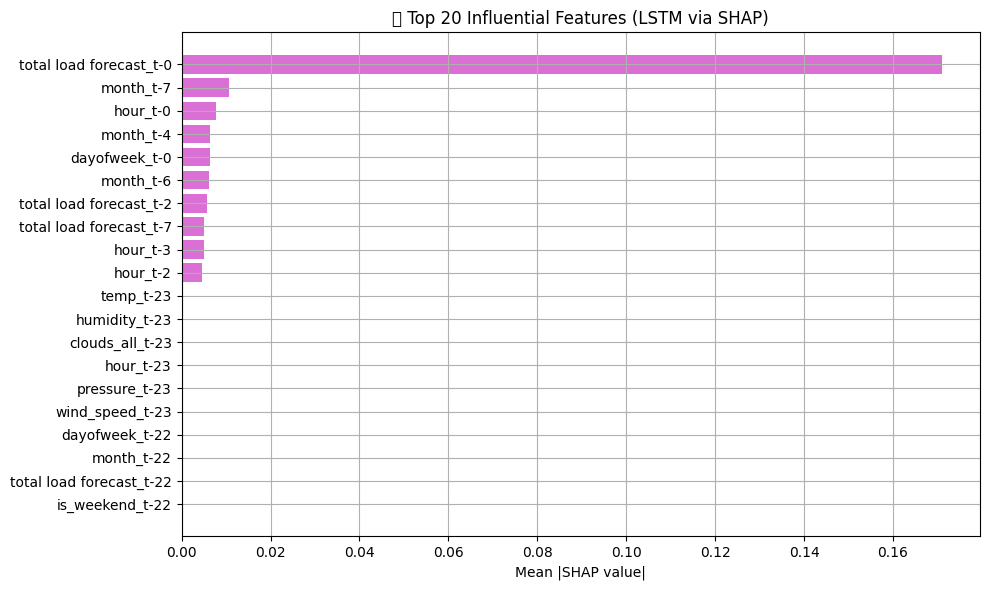

In [16]:
# === Step 9: Create SHAP summary DataFrame ===
shap_df = pd.DataFrame({
    'Feature': flattened_features,
    'Mean |SHAP|': mean_shap
}).sort_values('Mean |SHAP|', ascending=False)

# === Step 10: Plot top features ===
top_k = 20
plt.figure(figsize=(10, 6))
plt.barh(shap_df['Feature'].head(top_k), shap_df['Mean |SHAP|'].head(top_k), color='orchid')
plt.gca().invert_yaxis()
plt.title(f"🔍 Top {top_k} Influential Features (LSTM via SHAP)")
plt.xlabel("Mean |SHAP value|")
plt.grid(True)
plt.tight_layout()
plt.show()